In [1]:
import os
import ee
import time
import rioxarray

import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gp
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
from osgeo import gdal, osr
from shapely.geometry import box

ee.Initialize()

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
def gdf_to_ee_poly(gdf, simplify = False):

    if simplify:
        gdf = gdf.geometry.simplify(0.01)

    lls = gdf.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)

    return area

def array_from_df(df, variable):    

    '''
    Convets a pandas df with lat, lon, variable to a numpy array 
    '''

    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 

    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner

    return arr


def get_ims(ImageCollection, var_name, scale_factor, native_res, startdate, enddate, area):

    '''
    Returns gridded images for EE datasets 
    Params: 
    ImageCollection -> ee.ImageCollection objet e.g. ee.ImageCollection("USDA/NAIP/DOQQ")
    var_name -> name of the band
    scale_factor -> given with some datasets for compression 
    native_res -> spatial resolution 
    startdate -> MUST BE LIKE "YYYY-mm-dd"
    enddate -> Same^
    area -> ee.Geometry object 
    
    '''
    dt_idx = pd.date_range(startdate,enddate, freq='MS')
    ims = []

    start = ee.Date(startdate)
    end = ee.Date(enddate)
    im = ee.ImageCollection(ImageCollection.filterBounds(area).filterDate(start, end).set('system:time_start', end.millis()).select(var_name).mean())
    result = im.getRegion(area,native_res,"epsg:4326").getInfo()
    header, data = result[0], result[1:]

    df = pd.DataFrame(np.column_stack(data).T, columns = header)
    df.latitude = pd.to_numeric(df.latitude)
    df.longitude = pd.to_numeric(df.longitude)
    df[var_name] = pd.to_numeric(df[var_name])

    results = []
    images = []
    for idx,i in enumerate(df.id.unique()):

        t1 = df[df.id==i]
        arr = array_from_df(t1,var_name)
        arr[arr == 0] = np.nan
        images.append(arr*scale_factor)# This is the only good place to apply the scaling factor. 
    results.append(images) 
    results_out = [item for sublist in results for item in sublist]
    return results_out

def get_sentinel(geometry, startdate = '2022-01-01', enddate =  '2023-01-01'):
    # Get rgb bands For sentinel 

    r = get_ims(ee.ImageCollection("COPERNICUS/S2_HARMONIZED"), 'B4', 0.0001, 10, startdate, enddate, geometry)
    g = get_ims(ee.ImageCollection("COPERNICUS/S2_HARMONIZED"), 'B3', 0.0001, 10, startdate, enddate, geometry)
    b = get_ims(ee.ImageCollection("COPERNICUS/S2_HARMONIZED"), 'B2', 0.0001, 10, startdate, enddate, geometry)
    nir = get_ims(ee.ImageCollection("COPERNICUS/S2_HARMONIZED"), 'B8', 0.0001, 10, startdate, enddate, geometry)
    
    rn,gn,bn,nir = normalize(r[0]), normalize(g[0]), normalize(b[0]), normalize(nir[0])
    rgb = np.dstack((rn,gn,bn))
    
    return rgb

def get_naip(geometry, startdate ='2018-01-01', enddate = '2023-01-01'):

    r = get_ims(ee.ImageCollection("USDA/NAIP/DOQQ"), 'R', 1, 1, startdate, enddate, geometry)
    g = get_ims(ee.ImageCollection("USDA/NAIP/DOQQ"), 'G', 1, 1, startdate, enddate, geometry)
    b = get_ims(ee.ImageCollection("USDA/NAIP/DOQQ"), 'B', 1, 1, startdate, enddate, geometry)

    # Plot rgb 
    rn,gn,bn = normalize(r[0]), normalize(g[0]), normalize(b[0])
    rgb = np.dstack((rn,gn,bn))
    
    return rgb

def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return ((array - array_min)/(array_max - array_min))

def get_convex_hull(tiff_fn):
    
    print('determining convex hull')
    
    rds = rioxarray.open_rasterio(tiff_fn)
    rds.name = "data"
    df = rds.squeeze().to_dataframe().reset_index()

    geometry = gp.points_from_xy(df[df['band'] == 1].x, df[df['band'] == 1].y)
    gdf = gp.GeoDataFrame(df[df['band'] == 1], crs=rds.rio.crs, geometry=geometry)

    gdf[gdf['data'] == 0] = np.nan
    gdf.dropna(inplace = True)

    convex_hull = gdf[gdf.is_valid].unary_union.convex_hull 
    convex_hull = gp.GeoDataFrame(geometry=[convex_hull], crs=gdf.crs)
    
    return convex_hull

def write_raster(array,gdf,outfn):
    
    '''
    converts a numpy array and a geopandas gdf to a geotiff
    Data values are stored in np.array
    spatial coordinates stored in gdf
    outfn - outpath
    '''
    
    xmin, ymin = gdf.bounds.minx.values[0], gdf.bounds.miny.values[0]
    xmax, ymax = gdf.bounds.maxx.values[0], gdf.bounds.maxy.values[0]
    nrows, ncols = array.shape[0], array.shape[1]
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform =(xmin,xres,0,ymax,0, -yres)   

    output_raster = gdal.GetDriverByName('GTiff').Create(outfn,ncols, nrows, array.shape[2] , gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(geotransform)  # Specify coords
    srs = osr.SpatialReference()                 # Establish encoding
    srs.ImportFromEPSG(4326)                     # WGS84 lat long
    output_raster.SetProjection(srs.ExportToWkt() )   # Export coordinate system 
    
    for i in range(0,array.shape[2]):
        output_raster.GetRasterBand(i+1).WriteArray(array[:,:,i])   # Write array to raster
    
    print("wrote {}".format(outfn))
    return outfn

In [3]:
# Make reprojection dir if not exist 
if not os.path.exists("../composites/wgs84/"):
    os.mkdir("../composites/wgs84/")

# Read orthomosaic filenames 
im_fns = [os.path.join("../composites/", x) for x in os.listdir("../composites/") if x.endswith(".tif")]

# Setup outfns    
rpj_fns = [os.path.join("../composites/wgs84/", x) for x in [os.path.split(x)[1] for x in im_fns] ] 

In [4]:
for im_fn, rpj_fn in zip(im_fns,rpj_fns):
    src_fn = os.path.abspath(im_fn)
    dst_fn = os.path.abspath(rpj_fn)
    cmd = '''gdalwarp -t_srs "EPSG:4326" {} {} '''.format(src_fn, dst_fn)
    if not os.path.exists(dst_fn):
        os.system(cmd)
        print(cmd)
    

../composites/wgs84/OsoFlacoLake_vis.tif
wrote ../composites/naip/OsoFlacoLake_vis.tif
wrote ../composites/sentinel/OsoFlacoLake_vis.tif


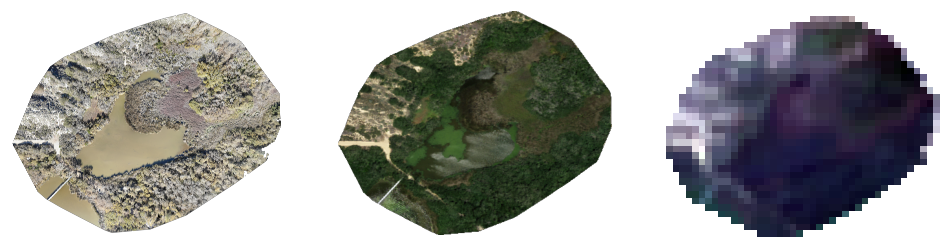

../composites/wgs84/KanabDam_vis.tif
wrote ../composites/naip/KanabDam_vis.tif
wrote ../composites/sentinel/KanabDam_vis.tif


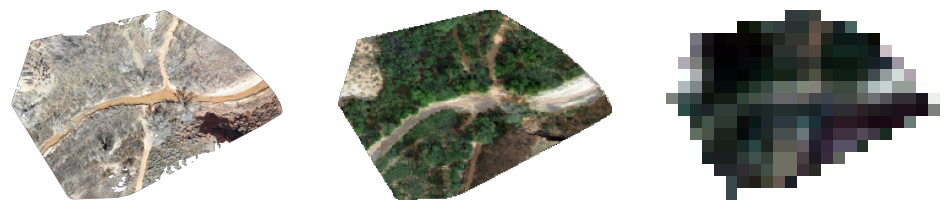

../composites/wgs84/OceanoDunes_tir.tif
wrote ../composites/naip/OceanoDunes_tir.tif
wrote ../composites/sentinel/OceanoDunes_tir.tif


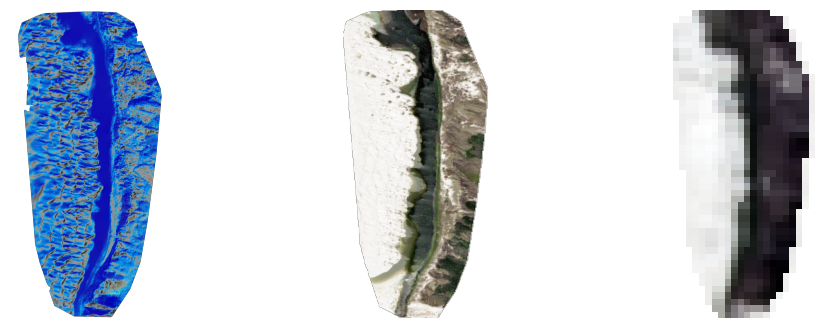

../composites/wgs84/OceanoDunes_vis.tif
wrote ../composites/naip/OceanoDunes_vis.tif
wrote ../composites/sentinel/OceanoDunes_vis.tif


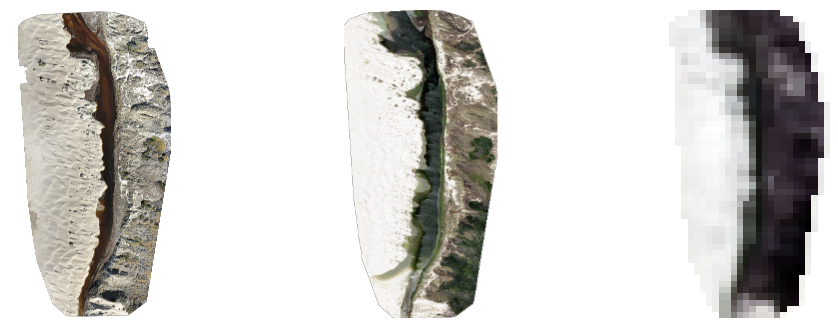

../composites/wgs84/KanabRiver_vis.tif
wrote ../composites/naip/KanabRiver_vis.tif
wrote ../composites/sentinel/KanabRiver_vis.tif


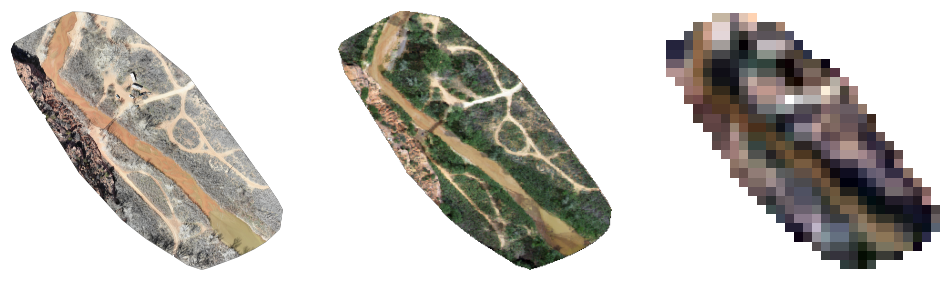

../composites/wgs84/KanabRiver_tir.tif
wrote ../composites/naip/KanabRiver_tir.tif
wrote ../composites/sentinel/KanabRiver_tir.tif


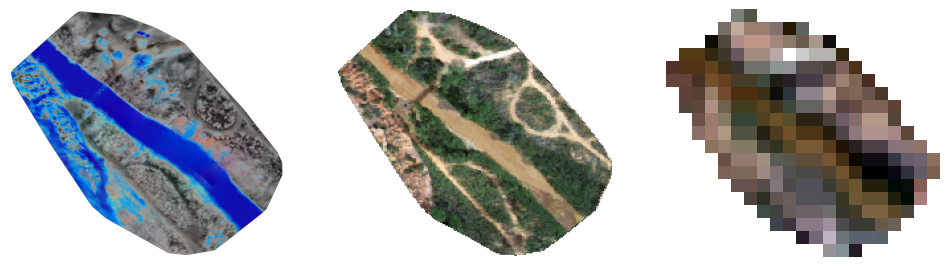

../composites/wgs84/OsoFlacoRiver_vis.tif
wrote ../composites/naip/OsoFlacoRiver_vis.tif
wrote ../composites/sentinel/OsoFlacoRiver_vis.tif


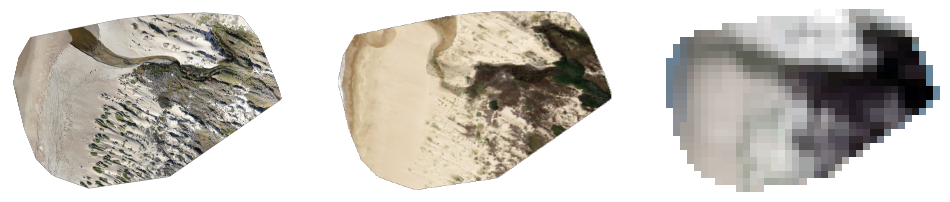

In [5]:
for rpj_fn in rpj_fns[:]:
    print("=====" * 10 )
    print(rpj_fn)
    # read fn
    src = rio.open(rpj_fn)
    # plot rgb im
    im = mpimg.imread(rpj_fn)

    # Get the geometry 
    shpfn = os.path.join('bounds',os.path.split(rpj_fn)[1].replace(".tif",".shp"))

    # Hull takes a long time to compute, so check if exists 
    if not os.path.exists(shpfn):
        # Get convex hull 
        gdf = get_convex_hull(rpj_fn)
        gdf.to_file(shpfn)
    else:
        gdf = gp.read_file(shpfn)

    # Define EE aoi
    aoi = gdf_to_ee_poly(gdf)
     
    # Get naip and plot
    try:
        naip = get_naip(aoi)
        alpha = np.ma.masked_invalid(naip[:,:,0]).data.astype(float)
        alpha[~np.isnan(alpha)] = 1
        # Write 
        naip_outfn = os.path.split(rpj_fn)[1]
        naip_outpath = os.path.join("../composites/naip",naip_outfn)
        write_raster(np.dstack([naip,alpha]),gdf, naip_outpath)
        # RGB Image 
        naipim = Image.fromarray((np.dstack([naip, alpha]) * 255).astype(np.uint8))
        naiprgb = naipim.convert('RGBA') # color image
    except:
        time.sleep(0.0)
        
    # Get sentinel and plot 
    s1 = get_sentinel(aoi)
    alpha = np.ma.masked_invalid(s1[:,:,0]).data.astype(float)
    # Write 
    s1_outfn = os.path.split(rpj_fn)[1]
    s1_outpath = os.path.join("../composites/sentinel",s1_outfn)
    write_raster(np.dstack([s1,alpha]),gdf, s1_outpath)
    # RGB image 
    alpha[~np.isnan(alpha)] = 1
    s1im = Image.fromarray((np.dstack([s1,alpha]) * 255).astype(np.uint8))
    s1imrgb = s1im.convert('RGBA') # color image

    plt.figure(figsize = (12,4))
    plt.subplot(131)
    plt.imshow(im); plt.axis("off"); 
    plt.subplot(132)
    plt.imshow(naiprgb); plt.axis("off");
    plt.subplot(133)
    plt.imshow(s1imrgb); plt.axis("off"); plt.show()
    
    